# ARMA Modeling Continued

__Overview__: This lab is meant to further improve your understanding of the ARMA model and the correlation functions we've been discussing in class. To get you more comfortable with the type of work you will need to do for the project, this will be less on-the-rails than the previous lab. You should take inspiration from the previous labs to help organize your code.

__Goals__: Students should:

1. Be able to identify a good ARMA model to apply on a dataset.
2. Be able to fit an ARMA model to the data.
3. Be able to display the conditional posterior coming from an ARMA process fit.

In [2]:
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_process import arma_acovf

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Part I: Identifying the Best ARMA Model

We will start from a pre-generated dataset for this lab. We believe that this data comes from a stationary process, and we would like to model the data as ARMA(p,q). The question is what the correct value of p and q are for this process. Using the ACF and PACF (you are free to use the implementations from statsmodels that are imported above) make an argument for why this data corresponds to an AR(3) process. This should include:

* Calculating the ACF, PACF, and expected error on both estimates (use the formulas from class).
* Plotting the data, the ACF, and the PACF along with the errors. This should be three seperate plots, one for the data, one for the ACF, and one for the PACF.
* Labeling all of the plots. This includes axes, sensible colors, and legends for each of your plots.

_Remember, the previous labs have copious examples of how to make nice plots. I would suggest using plt.subplots, fill_between, and stem._

__You will be graded on the quality of the plot you produce, not just the correctness of the information being presented.__

In [5]:
# TODO: Read the signal from the provided file. Be sure to convert to a numpy array!
df = pd.read_csv('arma_data.csv') # TODO
signal = df['signal'].values# TODO

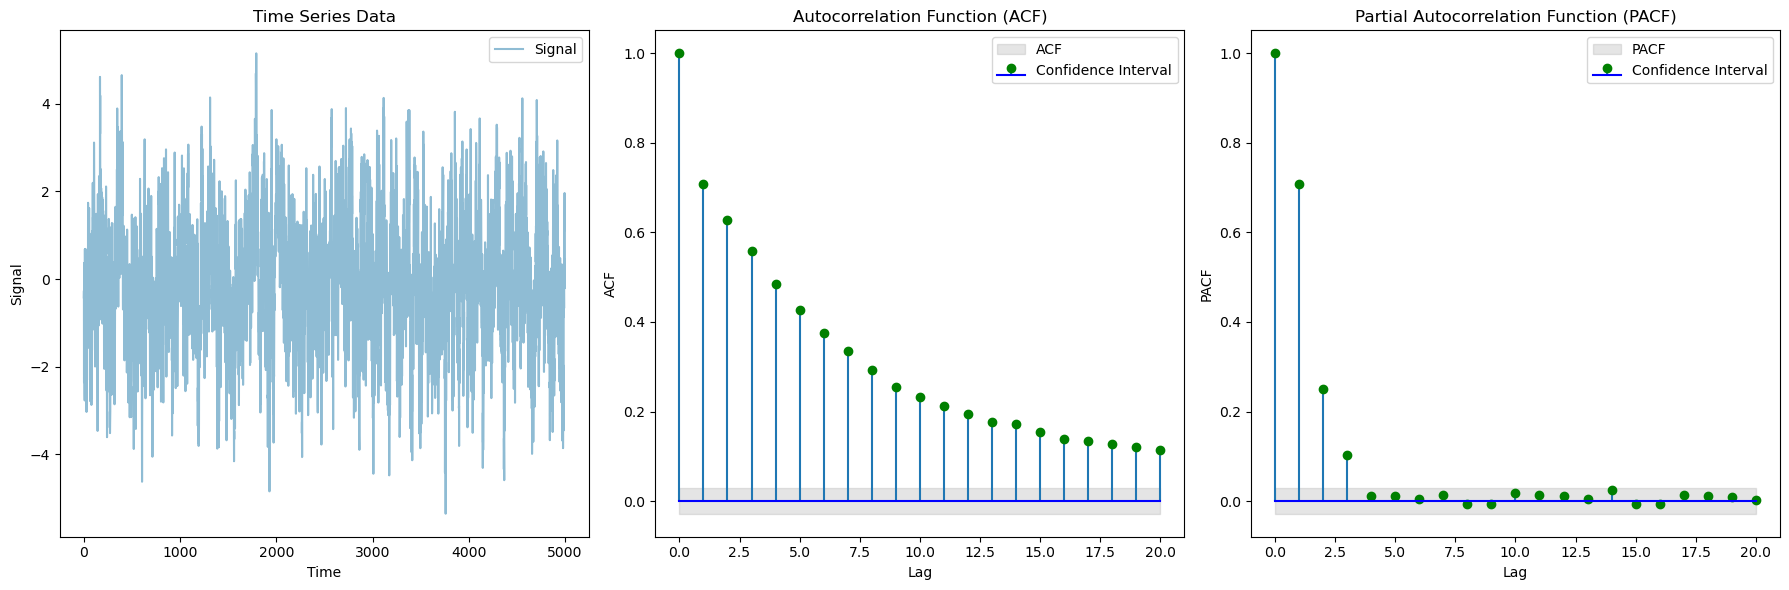

In [35]:
# TODO: Plot the ACF and PACF along with the expected error for the estimators.
n_lags = 20
acf_estimate = acf(signal, nlags=20)# TODO
pacf_estimate = pacf(signal, nlags=20) # TODO
acf_error_estimate = 2 / np.sqrt(len(signal)) # TODO
pacf_error_estimate = 2 / np.sqrt(len(signal)) # TODO

acf_error_estimate_array = np.full(len(acf_estimate), acf_error_estimate)

# TODO: Do the plotting here. See the previous labs for examples.
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Times series
ax[0].plot(signal, color='#8fbcd4', label='Signal')
ax[0].set_title('Time Series Data')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal')
ax[0].legend()

# ACF 
ax[1].stem(range(n_lags + 1), acf_estimate, linefmt='-', markerfmt='go', basefmt='b-')
ax[1].fill_between(range(len(acf_estimate)), - acf_error_estimate_array, acf_error_estimate_array, color='gray', alpha=0.2)
ax[1].set_title('Autocorrelation Function (ACF)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('ACF')
ax[1].legend(['ACF', 'Confidence Interval'])

# PACF 
ax[2].stem(range(n_lags + 1), pacf_estimate, linefmt='-', markerfmt='go', basefmt='b-')
ax[2].fill_between(range(len(acf_estimate)), - acf_error_estimate_array, acf_error_estimate_array, color='gray', alpha=0.2)
ax[2].set_title('Partial Autocorrelation Function (PACF)')
ax[2].set_xlabel('Lag')
ax[2].set_ylabel('PACF')
ax[2].legend(['PACF', 'Confidence Interval'])

plt.tight_layout()
plt.show()

# TODO: Make your argument in this cell based on the plots above. Convert this cell to markdown.

Our ACF curve decreases very slowly and does not converge to zero up to 20 steps. (As in the graph, we say convergence being within the grey range that if the process is only generated with white noise). This suggests that this process is more likely an AR process.

We then check our PACF curve. The PACF curve has a drop after time step 3, showing that the process is an AR(3) process.

## Part II: Fitting our AR(3) Model

You've hopefully made a reasonable argument that fitting the parameters of an AR(3) model will give us a good result. Now it's time to do that fit. To do this you will have to:

* Calculating the posterior for the parameters of an AR(3) process.
* Calculate the conditional distribution for an AR(3) process given its parameters.
* Plot samples and the conditional distirbution for our AR(3) process.


In [38]:
class ARThreeModel:
    """Class implementing prior, likelihood, posterior, and predictions for an AR(3) model.

    Args:
        sigma_phi: Sigma for the prior on parameters phi_1, phi_2, and phi_3.
        sigma_max: Maximum value for uniform prior on sigma_w.
    """

    def __init__(self: Any, sigma_phi: float, sigma_max: float):
        """Initialization funciton. See class docstring for parameters."""
        self.sigma_phi = sigma_phi
        self.sigma_max = sigma_max

    def log_prior(self: Any, params: np.ndarray) -> float:
        """Calculate the log prior of the parameters.

        Args:
            params: Parameters in the order [phi_1, phi_2, phi_3, sigma_w]

        Returns:
            Log prior of the parameters.

        Notes:
            You can use the norm and uniform functions to evaluate the log pdf. These functions come from scipy.stats.
        """
        # TODO: Implement
        phi_1, phi_2, phi_3, sigma_w = params

        log_prior_phi = norm.logpdf(phi_1, 0, self.sigma_phi) + \
                        norm.logpdf(phi_2, 0, self.sigma_phi) + \
                        norm.logpdf(phi_3, 0, self.sigma_phi)

        log_prior_sigma_w = uniform.logpdf(sigma_w, 0, self.sigma_max)
        return log_prior_phi + log_prior_sigma_w


    def log_likelihood(self: Any, data: np.ndarray, params: np.ndarray) -> float:
        """Calculate the log likelihood of the data given the parameters.

        Args:
            data: Observed time series.
            params: Parameters in the order [phi_1, phi_2, phi_3, sigma_w]

        Returns:
            Log likelihood of the data given the parameters.

        Notes:
            You may want to vectorize this function as much as possible to improve the speed of your code.
            This is not a requirement, just a suggestion.
        """
        # TODO: Implement
        phi1 = params[0]
        phi2 = params[1]
        phi3 = params[2]
        sigma = params[3]
        n = len(data)

        likelihood = 0

        likelihood += norm.logpdf(data[0], loc=0, scale=sigma)
        likelihood += norm.logpdf(data[1], loc=phi1 * data[0], scale=sigma)
        likelihood += norm.logpdf(data[2], loc=phi1 * data[1] + phi2 * data[0], scale=sigma)

        for i in range(3, n):
            mean = phi1 * data[i-1] + phi2 * data[i-2] + phi3 * data[i-3]
            likelihood += norm.logpdf(data[i], loc=mean, scale=sigma)
        
        return likelihood

    def log_posterior(self: Any, params: np.ndarray, data: np.ndarray) -> float:
        """Calcualte the log posterior of the parameters given the data.

        Args:
            params: Parameters in the order [phi_1, phi_2, sigma_w]
            data: Observed time series.

        Returns:
            Log posterior of the parameters given the data.

        Notes:
            Ignore the marginal of the data (the overall normalization of the posterior).
        """
        # TODO Implement
        log_prior_val = self.log_prior(params)
        log_likelihood_val = self.log_likelihood(data, params)
        return log_prior_val + log_likelihood_val
        
        

In [39]:
# Let's run some tests to make sure the implementations are correct.
a_model = ARThreeModel(2.0, 5.0)

phi_one, phi_two, phi_three = 0.5, 0.2, 0.1
sigma_w = 1.0
params_test = np.array([phi_one, phi_two, phi_three, sigma_w])
x_t = np.array([3.52810469, 3.2699877, 4.9520883, 8.60224575, 10.74710566, 7.28886735, 9.15180511, 7.56132263, 6.91684916, 7.17525595])

np.testing.assert_almost_equal(a_model.log_prior([0.3, 0.4, 0.5, 2.0]), -6.508195053727955)
np.testing.assert_almost_equal(a_model.log_prior([0.3, 0.4, 0.5, 6.0]), -np.inf)
np.testing.assert_almost_equal(a_model.log_likelihood(x_t, params_test), -50.47684010239573)
np.testing.assert_almost_equal(a_model.log_posterior(params_test, x_t), -56.96003515612368)

In [42]:
# Let's fit our model to the data using the priors.
sigma_phi = 2.0
sigma_max = 5.0
a_model_wide = ARThreeModel(sigma_phi, sigma_max)
# TODO run the fit with minimize from scipy. Results will be [phi_1, phi_2, phi_3, sigma_w].
params_zero = np.array([0.0, 0.0, 0.0, 1.0])
res = minimize(lambda params: -a_model_wide.log_posterior(params, signal), params_zero, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': False, 'maxiter': 10000})

results = res.x # TODO: Run the fit. See last week's lab for an example


for i in range(3):
    print(f'phi_{i} has MAP value of {results[i]}')
print(f'sigma_w has MAP value of {results[-1]}')

phi_0 has MAP value of 0.5058833684977462
phi_1 has MAP value of 0.19602831437660814
phi_2 has MAP value of 0.10407309583586902
sigma_w has MAP value of 1.0055145893854103


We want to calculate the conditional distribution of our AR(3) process. As we discussed in class, we can take advantage of the fact that all of the structure of our process can be captured by a multivariate Gaussian distribution. To use our conditional Gaussian equation from lecture we need a mean and a covariance matrix. The mean is easy, but we will need a function for the covariance matrix.

In [43]:
def ar_three_cov_matrix(phis: np.ndarray, max_h: int, sigma_w: float) -> np.ndarray:
    """Calculate the covariance matrix for an AR(3) process.

    Args:
        phis: Phi parameters of the AR(3) process.
        max_h: Maximum time index seperation to calculate the covariance matrix for.

    Returns:
        Covariance matrix up to lag of max_h.

    Notes:
        Use the function arma_acovf to calculate the . It takes as input ([phi_0, -phi_one, ...], [theta_0, theta_one, ...], max_h + 1, 
        sigma_w ** 2). Note that it requires a value of phi_0 and theta_0 (which we always take to be 1.0).
    """
    # TODO: Implement.
    phi_params = np.concatenate(([1.0], -phis))
    acovf_values = arma_acovf(phi_params, [1.0], max_h + 1, sigma_w**2)
    cov_matrix = np.zeros((max_h + 1, max_h + 1))

    for i in range(max_h + 1):
        for j in range(max_h + 1):
            cov_matrix[i, j] = acovf_values[abs(i - j)]

    return cov_matrix

In [44]:
# Let's quickly test you got the right answer.
cov_test = ar_three_cov_matrix(np.array([0.5, 0.2, 0.1]), 1, 1.5)
cov_correct = np.array([[4.795507, 3.369816], [3.369816, 4.795507]])
np.testing.assert_array_almost_equal(cov_test, cov_correct)

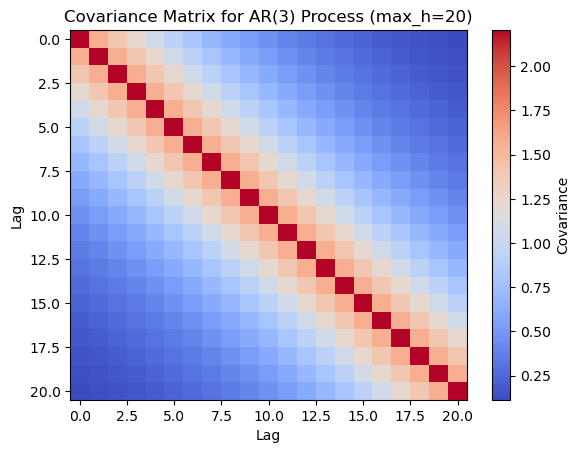

In [45]:
# TODO: Plot the covariance matrix for your fit parameters and a max_h of 20.
fit_params = results[:3]
sigma_w_fit = results[3]

cov_twenty = ar_three_cov_matrix(fit_params, 20, sigma_w_fit) # TODO: Calculate and plot. I recommend plt.imshow(). Labels are less important here, but a colorbar is good.

# 
plt.imshow(cov_twenty, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Covariance')
plt.title('Covariance Matrix for AR(3) Process (max_h=20)')
plt.xlabel('Lag')
plt.ylabel('Lag')
plt.show()

Does the structure make sense? How would it be different if it was an MA(3) process?

# TODO: Change this cell to markdown and write your answer to the question above.

Yes, it does. AR processes are driven by autoregressive terms that each time step is related to preceding n terms. This correponds to a diagonal structure in the above graph that diminishes gradually as we move away from the diagonal. If this is a MA(3) process, each value depends on three previous white noise terms, so the covariance will have non-zero entries only corresponds to the first 3 lags. Other terms will be EXACTLY zero.

Now we want the conditional distribution for the next m time steps given the past n. The equation can be found in the lecture notes.

In [47]:
def conditioned_mean_covariance(mu_vec: np.ndarray, covariance_matrix: np.ndarray, 
                                conditioned_observations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the conditioned mean and covariance matrix of a multivariate Gaussian.

    Args:
        mu_vec: Mean of distribution with length (n+m).
        covariance_matrix: Covariance matrix of the distribution with shape (n+m * n+m).
        conditioned_observations: First n observations that are being conditioned on.

    Returns:
        Mean and covariance of the next m observations.

    Notes:
        The code from Lab 2 may be useful, but notice that the calculation here is slightly different.
    """
    # TODO: Calculate the conditioned mean and covariance.
    n = len(conditioned_observations)
    m = len(mu_vec) - n

    Sigma_11 = covariance_matrix[:n, :n]
    Sigma_12 = covariance_matrix[:n, n:]
    Sigma_21 = covariance_matrix[n:, :n]
    Sigma_22 = covariance_matrix[n:, n:]

    mu_1 = mu_vec[:n]
    mu_2 = mu_vec[n:]


    conditioned_mean = mu_2 + Sigma_21 @ np.linalg.inv(Sigma_11) @ (conditioned_observations - mu_1)
    conditioned_covariance = Sigma_22 - Sigma_21 @ np.linalg.inv(Sigma_11) @ Sigma_12

    return conditioned_mean, conditioned_covariance


With the conditioned mean and covariance we can now better understand our model's fit. We want to do two things here:

1. Do one-step-ahead prediction using the previous 40 time steps to confirm that our model gives a reasonable fit to the data.
2. Predict the next 70 timesteps given the last 40 time steps in our signal (i.e. predict the future).

__Want to test the function you wrote above? The sample_x_future function from last week might be useful!__

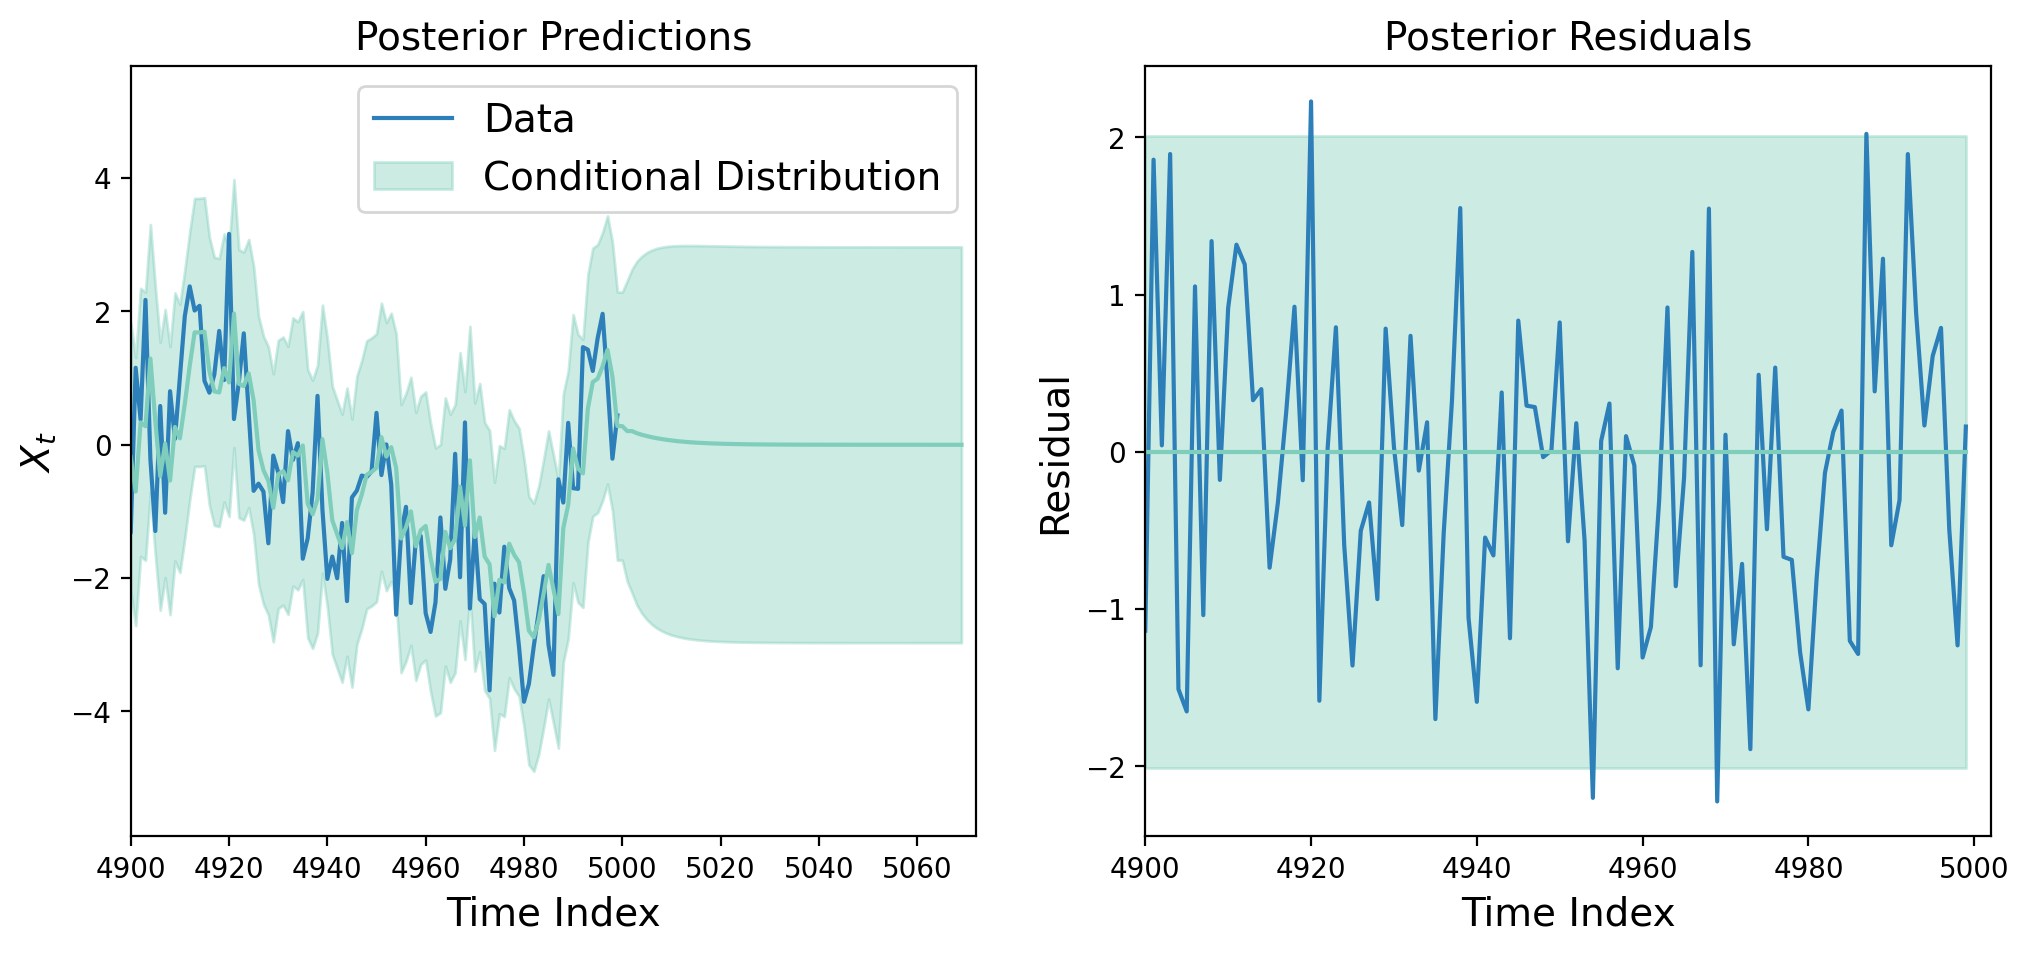

In [53]:
# Initialize our mean and covariances for the one ahead.
one_ahead_start = len(signal) - 100
mu_one_ahead = np.zeros(len(signal) - one_ahead_start)
cov_one_ahead = np.zeros(len(signal) - one_ahead_start) # Covariance matrix is a single value for one-ahead prediction.

n_lookback = 40
for time_step in range(one_ahead_start, len(signal)):
    # TODO: Use your function to calculate the covariance matrix for the time step in question using the last
    # 40 datapoints of signal.
    mu_joint = np.zeros(n_lookback + 1) # TODO
    cov_joint = ar_three_cov_matrix(fit_params, n_lookback, sigma_w_fit) # TODO
    mu_cond, cov_cond = conditioned_mean_covariance(mu_joint, cov_joint, signal[time_step - n_lookback:time_step]) # TODO
    
    mu_one_ahead[time_step - one_ahead_start] = mu_cond[0]
    cov_one_ahead[time_step - one_ahead_start] = cov_cond[0,0]

# TODO: Predict the next 70 timesteps given the last 40.
predict_next = 70
n_lookback = 40

mu_joint = np.zeros(n_lookback + predict_next) # TODO
cov_joint = ar_three_cov_matrix(fit_params, n_lookback + predict_next - 1, sigma_w_fit) # TODO
mu_future, cov_future = conditioned_mean_covariance(mu_joint, cov_joint, signal[-n_lookback:]) # TODO

mu_total = np.concatenate([mu_one_ahead, mu_future])
var_total = np.concatenate([cov_one_ahead, np.diag(cov_future)])

# Plot the result
colors = ['#7fcdbb', '#2c7fb8']
t_data = np.arange(len(signal))
t_cond = np.arange(one_ahead_start, len(signal))
t_total = np.arange(one_ahead_start, len(signal) + predict_next)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax1.plot(t_data, signal, color=colors[1], label='Data')
ax1.plot(t_total, mu_total, color=colors[0])
ax1.fill_between(t_total, mu_total - 2 * np.sqrt(var_total), mu_total + 2 * np.sqrt(var_total), 
                 color=colors[0], label=r'Conditional Distribution', alpha=0.4)

fontsize=14
ax1.set_xlim([one_ahead_start, len(signal) + predict_next + 2])
ax1.set_ylabel(r'$X_t$', fontsize=fontsize)
ax1.set_xlabel('Time Index', fontsize=fontsize)
ax1.set_title('Posterior Predictions', fontsize=fontsize)
ax1.legend(fontsize=fontsize)

# Plot the residual.
ax2.plot(t_cond, signal[one_ahead_start:] - mu_one_ahead, color=colors[1], label='Data')
ax2.plot(t_cond, np.zeros(len(t_cond)), color=colors[0])
ax2.fill_between(t_cond,  -2 * np.sqrt(cov_one_ahead), 2 * np.sqrt(cov_one_ahead), 
                 color=colors[0], label=r'Conditional Distribution', alpha=0.4)

ax2.set_xlim([one_ahead_start, len(signal) + 2])
ax2.set_ylabel(r'Residual', fontsize=fontsize)
ax2.set_xlabel('Time Index', fontsize=fontsize)
ax2.set_title('Posterior Residuals', fontsize=fontsize)

plt.show()


If everything worked, almost all of your residuals should fall within the conditional distribution contours.